In [1]:
import numpy as np
import cv2
import os
import scipy
import torch as th
from torch import nn, optim, distributions as dist
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import random
from tqdm import tqdm
import os
import torch.nn.functional as F
from torch.utils.data import Dataset 
from sklearn.model_selection import train_test_split
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
batch_size = 4
learning_rate = 1e-6
epochs = 200
density_map_scale = 10
#crop_size = 512
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda:0


In [3]:
images = []
labels = []
data_path = 'TRANCOS_v3/TRANCOS_v3/images'
for data in sorted(os.listdir(data_path)):
    basename = os.path.basename(data) # example.jpg
    #filename = os.path.splitext(basename)[0] # example
    file = os.path.splitext(basename)[1] #.jpg
    if file == '.jpg':
        images.append(data_path + '/' + basename)
    elif file == '.txt':
        labels.append(data_path + '/' + basename)

In [4]:
#generate density map and save
sigma = 4
for j in tqdm(range(len(images))):
    image = cv2.imread(images[j])
    '''if image.shape[0] < crop_size or image.shape[1] < crop_size:
        continue'''
    points = []    
    with open (labels[j], 'r') as f:
        while True:
            point = f.readline()
            if not point:
                break
            point = point.split('\t')
            points.append([float(point[0]), float(point[1])])
    label_position = np.array(points)
    #label_position = np.load(labels[j])
    label_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(label_position)):
        label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1
    density_map = scipy.ndimage.gaussian_filter(label_image, sigma = sigma, radius=7)
    if not os.path.isdir('density_map_npy_4'):
            os.mkdir('density_map_npy_4')
    basename_label = os.path.basename(labels[j]) # example.jpg
    filename_label = os.path.splitext(basename_label)[0] # example
    #np.save(('density_map_npy/'+filename_image+'.npy'),image)
    np.save(('density_map_npy_4/'+filename_label),density_map)

100%|██████████| 1244/1244 [00:43<00:00, 28.60it/s]


In [ ]:
#generate confident map and save
for j in tqdm(range(len(images))):
    image = cv2.imread(images[j])
    kernel = np.ones((15,15))
    points = []    
    with open (labels[j], 'r') as f:
        while True:
            point = f.readline()
            if not point:
                break
            point = point.split('\t')
            points.append([float(point[0]), float(point[1])])
    label_position = np.array(points)
    #label_position = np.load(labels[j])
    label_image = np.zeros((image.shape[0],image.shape[1]))
    for i in range(len(label_position)):
        label_image[int(label_position[i,1]) - 1, int(label_position[i,0]) - 1] = 1
    confident_map = signal.convolve2d(label_image, kernel, boundary='symm', mode='same') #卷積
    for i in range(confident_map.shape[0]):
        for k in range(confident_map.shape[1]):
            if confident_map[i][k] > 1:
                confident_map[i][k] = 1
    if not os.path.isdir('confident_map_npy_16'):
            os.mkdir('confident_map_npy_16')
    basename_label = os.path.basename(labels[j]) # example.jpg
    filename_label = os.path.splitext(basename_label)[0] # example
    np.save(('confident_map_npy_16/'+filename_label),confident_map)

100%|██████████| 1244/1244 [04:50<00:00,  4.28it/s]


In [4]:
density = []
data_path = 'density_map_npy_4'
for data in sorted(os.listdir(data_path)):
    basename = os.path.basename(data) # example.jpg
    density.append(data_path + '/' + basename)
    
confident = []
data_path = 'confident_map_npy_16'
for data in sorted(os.listdir(data_path)):
    basename = os.path.basename(data) # example.jpg
    confident.append(data_path + '/' + basename)
    
train_image, val_image, train_density, val_density, train_confident, val_confident = train_test_split(images, density, confident, test_size=0.2, random_state=42)
len(train_image), len(val_image)

(995, 249)

In [5]:
class TrainDataset(Dataset):
    def __init__(self, images = train_image, density = train_density, confident = train_confident, crop_size = 512):
      self.images = images
      self.density = density
      self.confident = confident
      self.density_map_scale = density_map_scale
    def __getitem__(self, index):
      # 讀取每次迭代的資料集中第 idx  資料
      image = cv2.imread(self.images[index])
      image = self.transform(image)
      
      density_map = np.load(self.density[index])
      density_map = np.expand_dims(density_map, axis=2)
      count = np.sum(density_map)
      density_map *= self.density_map_scale
      density_map = density_map.transpose((2, 0, 1))
      density_map = torch.from_numpy(density_map)
      
      confident_map = np.load(self.confident[index])
      confident_map = np.expand_dims(confident_map, axis=2)
      #confident_map *= self.confident_map_scale
      confident_map = confident_map.transpose((2, 0, 1))
      confident_map = torch.from_numpy(confident_map)

      return image, density_map, confident_map, count
    def __len__(self):
      return len(self.images)
    
    def transform(self, image):
      #image = torch.from_numpy(image)
      
      transform = transforms.Compose(
          [          
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
          ])
      image = transform(image)
      return image

In [6]:
train_dataset = TrainDataset()
train_loader =  torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

In [7]:
validation_dataset = TrainDataset(images=val_image, density = val_density, confident = val_confident)
validation_loader =  torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0)

In [ ]:
'''#CSRNet
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
        
        self.output_layer1 = nn.Conv2d(2, 32, kernel_size=1, padding='same')
        self.output_layer2 = nn.Conv2d(32, 1, kernel_size=3, padding='same')
        #self.output_layer3 = nn.Conv2d(16, 1, kernel_size=3, padding='same')
        #self.output_layer4 = nn.Conv2d(32, 32, kernel_size=5, padding='same')
        #self.output_layer5 = nn.Conv2d(32, 1, kernel_size=1, padding='same')
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = F.upsample_bilinear(x, scale_factor=8)
        
        confident = self.output_layer(x)
        
        
        density = self.output_layer(x)
        
        final = torch.cat([confident, density],dim=1)
        final = self.output_layer1(final)
        final = self.output_layer2(final)
        '''final = self.output_layer3(final)
        final = self.output_layer4(final)
        final = self.output_layer5(final)'''
        
        return confident, density, final
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)'''

In [8]:
#CSRNet
import torch.nn as nn
import torch
from torchvision import models

class CSRNet(nn.Module):
    def __init__(self, load_weights=False):
        super(CSRNet, self).__init__()
        self.seen = 0
        self.frontend_feat = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512]
        self.backend_feat  = [512, 512, 512,256,128,64]
        self.frontend = make_layers(self.frontend_feat)
        self.backend = make_layers(self.backend_feat,in_channels = 512,dilation = True)
        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)
        if not load_weights:
            mod = models.vgg16(pretrained = True)
            self._initialize_weights()
            for i in range(len(self.frontend.state_dict().items())):
                #self.frontend.state_dict().items()[i][1].data[:] = mod.state_dict().items()[i][1].data[:]
                list(self.frontend.state_dict().items())[i][1].data[:] = list(mod.state_dict().items())[i][1].data[:]
        
        self.output_layer1 = nn.Conv2d(2, 64, kernel_size=1, padding='same')
        self.output_layer2 = nn.Conv2d(64, 32, kernel_size=1, padding='same')
        self.output_layer3 = nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.output_layer4 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.output_layer5 = nn.Conv2d(16, 1, kernel_size=1, padding='same')
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    def forward(self,x):
        x = self.frontend(x)
        x = self.backend(x)
        x = F.upsample_bilinear(x, scale_factor=8)
        
        confident = self.output_layer(x)
        confident = self.sigmoid(confident)
        
        density = self.output_layer(x)
        
        final = torch.cat([confident, density],dim=1)
        final = self.output_layer1(final)
        final = self.output_layer2(final)
        final = self.output_layer3(final)
        final = self.output_layer4(final)
        final = self.output_layer5(final)
        final = self.relu(final)
        
        return confident, density, final
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            
                
def make_layers(cfg, in_channels = 3,batch_norm=False,dilation = False):
    if dilation:
        d_rate = 2
    else:
        d_rate = 1
    layers = []
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=d_rate,dilation = d_rate)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

In [9]:
model = CSRNet().to(device)

c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
x = torch.rand((1,3,480,640)).float().to(device)

In [55]:
y = model(x)

In [12]:
from torchsummary import summary
summary(model, input_size=(3,480,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 480, 640]           1,792
              ReLU-2         [-1, 64, 480, 640]               0
            Conv2d-3         [-1, 64, 480, 640]          36,928
              ReLU-4         [-1, 64, 480, 640]               0
         MaxPool2d-5         [-1, 64, 240, 320]               0
            Conv2d-6        [-1, 128, 240, 320]          73,856
              ReLU-7        [-1, 128, 240, 320]               0
            Conv2d-8        [-1, 128, 240, 320]         147,584
              ReLU-9        [-1, 128, 240, 320]               0
        MaxPool2d-10        [-1, 128, 120, 160]               0
           Conv2d-11        [-1, 256, 120, 160]         295,168
             ReLU-12        [-1, 256, 120, 160]               0
           Conv2d-13        [-1, 256, 120, 160]         590,080
             ReLU-14        [-1, 256, 1

c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


In [10]:
def validation(val_dataloader, criterion):
    print('\n---validation---')
    val_loss = 0.0
    val_mse = 0.0
    val_mae = 0.0
    model.eval()                   
    with torch.no_grad():
        for val_batch_idx, val_data in enumerate(val_dataloader):
            image = val_data[0]
            image = image.float()
            #image = image.cuda()
            target_density = val_data[1]
            target_density = target_density.float()
            #target_density = target_density.cuda()
            image, target_density = image.to(device), target_density.to(device)
            target_confident = val_data[2]
            target_confident = target_confident.float()
            pred_confident, pred_density, pred_final = model(image)
            #val_loss += (loss.item() * len(val_data))
            count = val_data[3]
            mae = 0
            mse = 0
            for i in range(len(pred_final)):
                predict_count = torch.sum(pred_final[i]).cpu().detach().numpy().item() / density_map_scale
                target_count = count[i].item()
                mse += np.square(predict_count - target_count)
                mae += np.abs(predict_count - target_count)
            print('batch:', val_batch_idx, 'val_mse:', mse / len(pred_final),'val_mae:', mae / len(pred_final), end='\r')
            val_mse += mse
            val_mae += mae
    validation_size = val_batch_idx*batch_size + len(val_data)
    #val_loss /= validation_size
    val_mse /= validation_size
    val_mae /= validation_size
    return val_mse, val_mae

In [11]:
from torch.nn.modules import Module
import math
class Weight_BCE(Module):
    def __init__(self):
        super(Weight_BCE, self).__init__()
        
    def forward(self, pre_density_list, target_list):
        loss = 0.0
        for i in range(len(pre_density_list)):
            predict = pre_density_list[i][0]
            target = target_list[i][0]
            fi = torch.mean(target)
            #predict = torch.sigmoid(predict)
            
            if fi == 0:
                error = -1e-6 * (target.mul(torch.log(predict)) + (1 - target).mul(torch.log(1 - predict)))
            else:
                error = -((1-2*fi)*target + fi)*(target.mul(torch.log(predict)) + (1 - target).mul(torch.log(1 - predict)))
            error = torch.mean(error)
            loss += error
            '''for j in range(predict.shape[0]):
                for k in range(predict.shape[1]):
                    error 
                    if fi == 0:
                        error = -1e-6 * (target[j][k] * torch.log(predict[j][k]) + (1 - target[j][k]) * torch.log(1 - predict[j][k]))
                    else:
                        error =  -((1 - 2*fi) * target[j][k] + fi) * (target[j][k] * torch.log(predict[j][k]) + (1 - target[j][k]) * torch.log(1 - predict[j][k]))
                    loss += error'''
        return loss

    

In [12]:
x = torch.rand((10,1,240,240))
y = torch.rand((10,1,240,240))
loss = Weight_BCE()
loss(x,y)

tensor(4.9931)

In [12]:
def train(model, train_dataloader, val_dataloader, epoch_size,learning_rate = 1e-3, optimizers = 'Adam', model_save_name = 'vgg19', validation_Flag = True, early_stoping_max = 20, loss_weight = True):
    criterion = torch.nn.MSELoss().cuda()
    #criterion2 = torch.nn.BCEWithLogitsLoss().cuda()
    criterion2 = Weight_BCE().cuda()
    history = dict()
    train_history_final_loss = []
    train_history_mse = []
    train_history_mae = []
    
    val_history_loss = []
    val_history_mse = []
    val_history_mae = []
    
    if optimizers == 'Adam':
        lr = learning_rate
        optimizer = optim.Adam(model.parameters(), lr)
        
    best_mae = np.inf    
    early_stoping_count = 0
    early_stoping_max = early_stoping_max
    
    if optimizers == 'SGD':
        optimizer = optim.SGD(model.parameters(
        ), lr=learning_rate, momentum=0.9, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.StepLR(
        optimizer, step_size=5, gamma=0.1)
   
    for epoch in tqdm(range(epoch_size)):
        #optimizer = optim.Adam(model.parameters(), lr)
        #train_confident_loss = 0.0
        #train_density_loss = 0.0
        train_final_loss = 0.0
        train_mse = 0.0
        train_mae = 0.0
        for batch_idx, data in enumerate(train_dataloader):
            model.train()
            image = data[0]
            image = image.float()
            #image = image.cuda()
            target_density = data[1]
            target_density = target_density.float()
            #target_density = target_density.cuda()
            image, target_density = image.to(device), target_density.to(device)
            target_confident = data[2]
            target_confident = target_confident.float().to(device)
            # clear gradient
            optimizer.zero_grad()
            # Forward propagation
            pred_confident, pred_density, pred_final = model(image)  

            loss1 = criterion2(pred_confident, target_confident)
            #print(loss1.item())
            #loss1.backward(retain_graph=True)
            #train_confident_loss += (loss1.item() * len(data))
            loss2 = criterion(pred_density, target_density) 
            #loss2.backward(retain_graph=True)
            #print(loss2.item())
            #train_density_loss += (loss2.item() * len(data))
            loss3 = criterion(pred_final, target_density)
            loss = loss1 + loss2 + loss3
            #print('loss1,', loss1.item(),'loss2:', loss2.item(),'loss3:', loss3.item(),'total loss:', loss.item(), end='\r')
            loss1.backward(retain_graph=True)
            loss2.backward(retain_graph=True)
            loss3.backward()
            #print(loss3.item())
            optimizer.step()
            train_final_loss += (loss.item() * len(data))
            
            count = data[3]
            #factor = data[3]
           
            mae = 0
            mse = 0
            for i in range(len(pred_final)):   
                target_count = count[i].item() 
                predict_count = torch.sum(pred_final[i]).cpu().detach().numpy().item() / density_map_scale
                mse += np.square(predict_count - target_count)
                mae += np.abs(predict_count - target_count)
            print('batch:', batch_idx,'loss1:', loss1.item(),'loss2:', loss2.item(),'loss3:', loss3.item(),'total loss:', loss.item(), 'train_mse:', mse / len(pred_final),'train_mae:', mae / len(pred_final), end='\r')
            train_mse += mse 
            train_mae += mae
            
        #print training result
        train_history_mse.append(train_mse/(batch_idx*batch_size + len(data)))
        train_history_mae.append(train_mae/(batch_idx*batch_size + len(data)))
        print('\ntrain mse:', train_mse/(batch_idx*batch_size + len(data)), 'train mae', train_mae/(batch_idx*batch_size + len(data)))
        train_history_final_loss.append(train_final_loss/(batch_idx*batch_size + len(data)))
        print("train fina loss:",train_final_loss/(batch_idx*batch_size + len(data)))
        
        if validation_Flag:
            val_mse, val_mae = validation(val_dataloader, criterion)                        
            #val_history_mse.append(val_mse)
            val_history_mae.append(val_mae)
            print('val mse:', val_mse, 'val mae', val_mae)
            #val_history_loss.append(val_loss)
            #print("val loss:",val_loss)
            
            if not os.path.isdir('save_weights'):
                os.mkdir('save_weights')
            #save weight
            if val_mae < best_mae:
                best_mae = val_mae
                early_stoping_count = 0
                torch.save(model, "./save_weights/"+ model_save_name+".pt")
                print('\nmodel improve!')
            #check earlystoping
            early_stoping_count += 1
            if early_stoping_count > early_stoping_max:
                print('validation loss not improve in ', early_stoping_count,'epochs, early stoping!')
                break
     
    torch.save(model, "./save_weights/" +model_save_name +"_ final" +"_.pt")      
    history['train_mse'] = train_history_mse
    history['train_mae'] = train_history_mae
    history['train final_loss'] = train_history_final_loss
    if validation_Flag:
        history['val_mse'] = val_history_mse
        history['val_mae'] = val_history_mae
        #history['val_loss'] = val_history_loss
    return history

In [18]:
#torch.cuda.empty_cache()

In [13]:
history = train(model=model, train_dataloader=train_loader, val_dataloader = validation_loader, epoch_size=epochs, learning_rate=learning_rate,optimizers="Adam", model_save_name='CSRNet_3output_weight_sigma4_relu')

  0%|          | 0/200 [00:00<?, ?it/s]c:\Users\hsu\anaconda3\envs\meta\lib\site-packages\torch\nn\functional.py:4079: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


batch: 248 loss1: 0.06123336777091026 loss2: 0.0022379879374057055 loss3: 0.00970868207514286 total loss: 0.07318003475666046 train_mse: 9113426.140569508 train_mae: 3018.8397135416675476
train mse: 12037909.874133993 train mae 3457.2458662776103
train fina loss: 0.15333400556002277

---validation---
val mse: 8900747.13435706 val mae 2965.5695537264389833984375246


  0%|          | 1/200 [07:17<24:11:19, 437.59s/it]


model improve!
batch: 248 loss1: 0.06075321137905121 loss2: 0.0030353849288076162 loss3: 0.0052614035084843636 total loss: 0.06904999911785126 train_mse: 4914955.24072525 train_mae: 2216.96236979166775
train mse: 6760067.836564747 train mae 2588.356393150727
train fina loss: 0.14539358711027237

---validation---


  1%|          | 2/200 [12:42<20:25:25, 371.34s/it]

val mse: 4779980.754452055 val mae 2173.2235824342756187503125

model improve!
batch: 248 loss1: 0.060730814933776855 loss2: 0.0033179009333252907 loss3: 0.002546421019360423 total loss: 0.06659513711929321 train_mse: 2349063.714107275 train_mae: 1532.65419921875016
train mse: 3446331.7293557115 train mae 1844.9358778865471
train fina loss: 0.14102948361252207

---validation---


  2%|▏         | 3/200 [18:01<19:01:03, 347.53s/it]

val mse: 2269465.0009387415 val mae 1497.420486111110783984375

model improve!
batch: 248 loss1: 0.0607181154191494 loss2: 0.0035016273614019156 loss3: 0.0010709725320339203 total loss: 0.06529071927070618 train_mse: 952313.4286734773 train_mae: 975.8472656258746124
train mse: 1525071.9584573545 train mae 1223.772823814791
train fina loss: 0.13849692971232425

---validation---


  2%|▏         | 4/200 [23:20<18:18:36, 336.31s/it]

val mse: 909112.4739319182 val mae 947.684480019221233007812576

model improve!
batch: 248 loss1: 0.06074613332748413 loss2: 0.00355330528691411 loss3: 0.00039772066520527005 total loss: 0.06469716131687164 train_mse: 313226.1295605627 train_mae: 559.6338867187506252
train mse: 558344.7638808376 train mae 737.0373534175772
train fina loss: 0.13715938445794057

---validation---


  2%|▎         | 5/200 [28:40<17:53:10, 330.21s/it]

val mse: 292002.4483623171 val mae 536.972330922929135742187538

model improve!
batch: 248 loss1: 0.06078597158193588 loss2: 0.003547677071765065 loss3: 0.00015505283954553306 total loss: 0.06448870152235031 train_mse: 81729.70284076076 train_mae: 285.8205322265625365
train mse: 161305.64477208364 train mae 393.37664084070667
train fina loss: 0.13651164354808837

---validation---


  3%|▎         | 6/200 [34:00<17:36:24, 326.72s/it]

val mse: 72334.04751198304 val mae 266.992219664558433007812587

model improve!
batch: 248 loss1: 0.060824159532785416 loss2: 0.003520840546116233 loss3: 8.880656969267875e-05 total loss: 0.06443380564451218 train_mse: 17698.833324910203 train_mae: 132.900301106770839
train mse: 35717.37135588606 train mae 183.1978582175381
train fina loss: 0.1361999623327849

---validation---


  4%|▎         | 7/200 [39:25<17:29:25, 326.24s/it]

val mse: 13891.960468540678 val mae 116.355849541558198710937544

model improve!
batch: 248 loss1: 0.06085877865552902 loss2: 0.0034868409857153893 loss3: 7.487397670047358e-05 total loss: 0.06442049145698547 train_mse: 3870.924644840869 train_mae: 61.92472534179688625
train mse: 6237.153852721642 train mae 75.00208143364469
train fina loss: 0.13601992243384742

---validation---


  4%|▍         | 8/200 [44:56<17:28:36, 327.69s/it]

val mse: 2381.9428245323093 val mae 46.5483911907862206347656258

model improve!
batch: 248 loss1: 0.06088785082101822 loss2: 0.0034522342029958963 loss3: 7.224073488032445e-05 total loss: 0.06441232562065125 train_mse: 1248.0568871354683 train_mae: 34.8136006673177118
train mse: 1084.822207458275 train mae 29.738233040805817
train fina loss: 0.13588685455571217

---validation---


  4%|▍         | 9/200 [50:23<17:22:18, 327.43s/it]

val mse: 591.2296804458058 val mae 21.16310112362816849121093754

model improve!
batch: 248 loss1: 0.060910869389772415 loss2: 0.0034172171726822853 loss3: 7.155410276027396e-05 total loss: 0.06439964473247528 train_mse: 725.417837368312 train_mae: 26.25986938476562675
train mse: 356.7325170850116 train mae 16.187965396130416
train fina loss: 0.13577454800466937

---validation---


  5%|▌         | 10/200 [55:41<17:08:21, 324.74s/it]

val mse: 323.59918929969905 val mae 15.3418685307578455351562506

model improve!
batch: 248 loss1: 0.060928598046302795 loss2: 0.0033844588324427605 loss3: 7.11847678758204e-05 total loss: 0.06438423693180084 train_mse: 613.0077339100217 train_mae: 24.02987263997396367
train mse: 253.20632852331659 train mae 13.279408006782992
train fina loss: 0.1356757305053822

---validation---


  6%|▌         | 11/200 [1:01:00<16:57:28, 323.01s/it]

val mse: 276.7490166367273 val mae 14.154079170832556278320312547

model improve!
batch: 248 loss1: 0.06094246357679367 loss2: 0.003355202730745077 loss3: 7.08556835888885e-05 total loss: 0.06436852365732193 train_mse: 591.4557249493835 train_mae: 23.5835408528645872765
train mse: 234.76661668044156 train mae 12.672153935566476
train fina loss: 0.13558733056348013

---validation---


  6%|▌         | 12/200 [1:06:19<16:47:44, 321.62s/it]

val mse: 268.3557086301439 val mae 13.92755215357219772851562504

model improve!
batch: 248 loss1: 0.06095346808433533 loss2: 0.003327561542391777 loss3: 7.05069542163983e-05 total loss: 0.06435153633356094 train_mse: 588.3554086633679 train_mae: 23.5249114990234359147
train mse: 230.02471127014869 train mae 12.519549992572825
train fina loss: 0.13550751590465446

---validation---


  6%|▋         | 13/200 [1:11:37<16:39:14, 320.61s/it]

val mse: 267.2752564439467 val mae 13.898816184392055292724609382

model improve!
batch: 248 loss1: 0.06096435338258743 loss2: 0.003298306604847312 loss3: 7.012813875917345e-05 total loss: 0.06433278322219849 train_mse: 587.7196329819226 train_mae: 23.51935831705729647
train mse: 227.51822888934885 train mae 12.447194984160275
train fina loss: 0.13543461161444945

---validation---


  7%|▋         | 14/200 [1:16:56<16:32:03, 320.02s/it]

val mse: 267.232729274675 val mae 13.8969326685345321967773437542

model improve!
batch: 248 loss1: 0.060971204191446304 loss2: 0.003275509923696518 loss3: 6.971583934500813e-05 total loss: 0.06431642919778824 train_mse: 588.973801983536 train_mae: 23.555467732747454752
train mse: 225.17299234123058 train mae 12.38117793132981
train fina loss: 0.13536760671789866

---validation---


  8%|▊         | 15/200 [1:22:14<16:24:49, 319.40s/it]

val mse: 267.8873202593327 val mae 13.910312083410837227050781334
batch: 248 loss1: 0.060976795852184296 loss2: 0.003253628732636571 loss3: 6.927068898221478e-05 total loss: 0.06429969519376755 train_mse: 588.4317721460511 train_mae: 23.55431315104167047
train mse: 222.5910529654471 train mae 12.307641491257998
train fina loss: 0.13530548530290404

---validation---


  8%|▊         | 16/200 [1:27:33<16:18:53, 319.21s/it]

val mse: 268.13666880683996 val mae 13.9092275347028507153320315
batch: 248 loss1: 0.06098330020904541 loss2: 0.003229191293939948 loss3: 6.87964420649223e-05 total loss: 0.06428129225969315 train_mse: 587.1769805384614 train_mae: 23.5388305664062548475
train mse: 219.67990207397767 train mae 12.219128981747293
train fina loss: 0.13524778666027099

---validation---


  8%|▊         | 17/200 [1:32:52<16:13:25, 319.15s/it]

val mse: 268.3270354074665 val mae 13.90172295948815844726562513
batch: 248 loss1: 0.06098842993378639 loss2: 0.003204645123332739 loss3: 6.829317135270685e-05 total loss: 0.06426136940717697 train_mse: 584.5346578931964 train_mae: 23.494560750325525875
train mse: 216.36278236572494 train mae 12.112776383242934
train fina loss: 0.1351933964344871

---validation---


  9%|▉         | 18/200 [1:38:10<16:07:44, 319.04s/it]

val mse: 268.36217440964776 val mae 13.8903764391702362011718755

model improve!
batch: 248 loss1: 0.060991592705249786 loss2: 0.0031836265698075294 loss3: 6.776559894206002e-05 total loss: 0.06424298137426376 train_mse: 580.0568344338114 train_mae: 23.411570231119793
train mse: 212.6302585823041 train mae 11.989968525836748
train fina loss: 0.1351420558600062

---validation---


 10%|▉         | 19/200 [1:43:29<16:01:58, 318.89s/it]

val mse: 267.9381820709094 val mae 13.86693258134145392163085944

model improve!
batch: 248 loss1: 0.060991737991571426 loss2: 0.0031674576457589865 loss3: 6.721731915604323e-05 total loss: 0.0642264112830162 train_mse: 573.708713918083 train_mae: 23.288626098632815377
train mse: 208.3187800818491 train mae 11.843033909318923
train fina loss: 0.13509326338408942

---validation---


 10%|█         | 20/200 [1:48:47<15:56:14, 318.75s/it]

val mse: 267.2969766830418 val mae 13.835553208608479235107421877

model improve!
batch: 248 loss1: 0.060993876308202744 loss2: 0.003144811140373349 loss3: 6.665454566245899e-05 total loss: 0.0642053410410881 train_mse: 564.0965779586044 train_mae: 23.09399108886718806
train mse: 203.26062348518832 train mae 11.669744159131643
train fina loss: 0.13504656365358206

---validation---


 10%|█         | 21/200 [1:54:21<16:04:30, 323.30s/it]

val mse: 265.9924897195431 val mae 13.781704397050158846679687505

model improve!
batch: 248 loss1: 0.060995250940322876 loss2: 0.003125518560409546 loss3: 6.608178955502808e-05 total loss: 0.06418684870004654 train_mse: 547.0717876362211 train_mae: 22.73527323404947661
train mse: 197.2152193629182 train mae 11.465709554526704
train fina loss: 0.13500184532868337

---validation---


 11%|█         | 22/200 [2:00:12<16:23:11, 331.41s/it]

val mse: 262.02832378721814 val mae 13.6555095490955142421875504

model improve!
batch: 248 loss1: 0.06099731847643852 loss2: 0.0031033591367304325 loss3: 6.550264515681192e-05 total loss: 0.06416618078947067 train_mse: 520.3719306097987 train_mae: 22.15282796223958437
train mse: 189.64735088793248 train mae 11.207270619955413
train fina loss: 0.13495895829066695

---validation---


 12%|█▏        | 23/200 [2:06:01<16:33:57, 336.94s/it]

val mse: 254.9054478375916 val mae 13.45119816613575419018554688

model improve!
batch: 248 loss1: 0.06099717319011688 loss2: 0.00308480067178607 loss3: 6.492414831882343e-05 total loss: 0.06414689868688583 train_mse: 476.4576019509572 train_mae: 21.149348958333334578
train mse: 179.8714680812448 train mae 10.875549111117323
train fina loss: 0.13491765038675094

---validation---


 12%|█▏        | 24/200 [2:11:57<16:45:08, 342.66s/it]

val mse: 241.10488722257455 val mae 13.0595431857638884335937506

model improve!
batch: 248 loss1: 0.060996342450380325 loss2: 0.0030676403548568487 loss3: 6.43447128823027e-05 total loss: 0.0641283243894577 train_mse: 409.0240303197285 train_mae: 19.499598185221355348
train mse: 167.65013138535866 train mae 10.460169878733684
train fina loss: 0.13487780001388497

---validation---


 12%|█▎        | 25/200 [2:17:55<16:52:28, 347.14s/it]

val mse: 218.40509425220245 val mae 12.39698516603581494140625697

model improve!
batch: 248 loss1: 0.06099659204483032 loss2: 0.0030485913157463074 loss3: 6.375644443323836e-05 total loss: 0.0641089379787445 train_mse: 322.81528847675776 train_mae: 17.1588114420572964
train mse: 153.4106021598833 train mae 9.946162560091448
train fina loss: 0.13483936656790085

---validation---


 13%|█▎        | 26/200 [2:23:52<16:55:29, 350.17s/it]

val mse: 188.1615085140199 val mae 11.464274209643166369995117194

model improve!
batch: 248 loss1: 0.06099759414792061 loss2: 0.0030289830174297094 loss3: 6.313608901109546e-05 total loss: 0.06408971548080444 train_mse: 228.80413917505496 train_mae: 14.193214925130212
train mse: 138.89958587012217 train mae 9.37878273347296
train fina loss: 0.13480227718870325

---validation---


 14%|█▎        | 27/200 [2:29:42<16:49:08, 349.99s/it]

val mse: 154.51788873160046 val mae 10.29142980424185302636718752

model improve!
batch: 248 loss1: 0.06099628284573555 loss2: 0.00301338080316782 loss3: 6.247515557333827e-05 total loss: 0.0640721395611763 train_mse: 157.82382975519948 train_mae: 11.502711995442713845
train mse: 126.30654728511416 train mae 8.830472797562319
train fina loss: 0.13476645348062477

---validation---


 14%|█▍        | 28/200 [2:35:34<16:45:04, 350.61s/it]

val mse: 130.19063839257566 val mae 9.309140190245612188110351563

model improve!
batch: 248 loss1: 0.0609959177672863 loss2: 0.002996365539729595 loss3: 6.176550959935412e-05 total loss: 0.06405404955148697 train_mse: 112.91143873681933 train_mae: 9.379598999023438263
train mse: 117.74704531910649 train mae 8.374901617578717
train fina loss: 0.13473178299675026

---validation---


 14%|█▍        | 29/200 [2:41:29<16:42:47, 351.86s/it]

val mse: 115.31350754398804 val mae 8.58755025106763164648437536

model improve!
batch: 248 loss1: 0.06099417805671692 loss2: 0.0029800275806337595 loss3: 6.0990943893557414e-05 total loss: 0.06403519958257675 train_mse: 84.78643537632189 train_mae: 7.6838389078776054
train mse: 113.09394118634025 train mae 8.032686693122594
train fina loss: 0.13469806325483513

---validation---


 15%|█▌        | 30/200 [2:47:17<16:34:25, 350.98s/it]

val mse: 107.01768717687928 val mae 8.11132537599594199023437504

model improve!
batch: 248 loss1: 0.060992106795310974 loss2: 0.002965328050777316 loss3: 6.0144408053020015e-05 total loss: 0.06401757895946503 train_mse: 66.06409813882782 train_mae: 6.48091023763020852
train mse: 111.57532211762212 train mae 7.813363831301769
train fina loss: 0.13466518967745295

---validation---


 16%|█▌        | 31/200 [2:53:06<16:26:43, 350.32s/it]

val mse: 103.01990051687459 val mae 7.8040457104879723344726563

model improve!
batch: 248 loss1: 0.06099105626344681 loss2: 0.002948879264295101 loss3: 5.9248788602417335e-05 total loss: 0.06399918347597122 train_mse: 53.037636609608285 train_mae: 6.2015981038411457
train mse: 112.47696341905086 train mae 7.7011050703056325
train fina loss: 0.13463311878792253

---validation---


 16%|█▌        | 32/200 [2:58:56<16:20:17, 350.10s/it]

val mse: 101.86189879645258 val mae 7.6217439681764615200195316

model improve!
batch: 248 loss1: 0.0609872080385685 loss2: 0.0029377650935202837 loss3: 5.8320696552982554e-05 total loss: 0.06398329883813858 train_mse: 43.98999193263861 train_mae: 5.96662902832031253
train mse: 115.243934188837 train mae 7.678658855392276
train fina loss: 0.1346018060922144

---validation---


 16%|█▋        | 33/200 [3:04:52<16:19:43, 351.99s/it]

val mse: 102.79095394057981 val mae 7.578558101351297239990234418

model improve!
batch: 248 loss1: 0.060984887182712555 loss2: 0.0029239433351904154 loss3: 5.7370074500795454e-05 total loss: 0.06396619975566864 train_mse: 37.83392685656511 train_mae: 5.767464701334634
train mse: 119.6952906693475 train mae 7.729380073700565
train fina loss: 0.1345712457555365

---validation---


 17%|█▋        | 34/200 [3:10:41<16:11:32, 351.16s/it]

val mse: 105.47282259017271 val mae 7.588788211156456092529296903
batch: 248 loss1: 0.06098267808556557 loss2: 0.0029102570842951536 loss3: 5.641284951707348e-05 total loss: 0.063949353992939 train_mse: 33.99778755707354 train_mae: 5.5806671142578111351
train mse: 125.69231010573249 train mae 7.8491547764544505
train fina loss: 0.13454142242789746

---validation---


 18%|█▊        | 35/200 [3:16:32<16:05:05, 350.94s/it]

val mse: 109.68404585878658 val mae 7.64153763907296180725097656534
batch: 248 loss1: 0.060979146510362625 loss2: 0.002898704493418336 loss3: 5.545046224142425e-05 total loss: 0.06393329799175262 train_mse: 32.11208487499193 train_mae: 5.39045918782552434
train mse: 133.0941843688937 train mae 8.045788531322556
train fina loss: 0.13451229218378602

---validation---


 18%|█▊        | 36/200 [3:22:27<16:02:28, 352.13s/it]

val mse: 115.10249752913035 val mae 7.743458956763858064086914013
batch: 248 loss1: 0.060975827276706696 loss2: 0.0028850059024989605 loss3: 5.449029049486853e-05 total loss: 0.06391532719135284 train_mse: 31.92678457925093 train_mae: 5.1889567057291645
train mse: 141.84216929459842 train mae 8.299466901419146
train fina loss: 0.1344837816544326

---validation---


 18%|█▊        | 37/200 [3:28:16<15:53:54, 351.13s/it]

val mse: 121.94475437999652 val mae 7.910231242104181185546874957
batch: 248 loss1: 0.0609729140996933 loss2: 0.0028723981231451035 loss3: 5.3556876082438976e-05 total loss: 0.06389886885881424 train_mse: 33.44481312359138 train_mae: 4.985109965006509295
train mse: 151.80826658511242 train mae 8.613307651841493
train fina loss: 0.13445576238464638

---validation---


 19%|█▉        | 38/200 [3:34:04<15:46:10, 350.43s/it]

val mse: 129.84902209998884 val mae 8.121066247849233318725585895
batch: 248 loss1: 0.06096890568733215 loss2: 0.0028605444822460413 loss3: 5.266118751023896e-05 total loss: 0.06388211250305176 train_mse: 36.4351778373153 train_mae: 4.771635945638019338
train mse: 162.84750006971174 train mae 8.970720357014
train fina loss: 0.1344283896098175

---validation---


 20%|█▉        | 39/200 [3:39:54<15:39:27, 350.11s/it]

val mse: 138.73854180473876 val mae 8.373428256927976496826171825
batch: 248 loss1: 0.06096402183175087 loss2: 0.002851770957931876 loss3: 5.1829207222908735e-05 total loss: 0.06386762112379074 train_mse: 40.68813199148898 train_mae: 4.594095357259112793
train mse: 174.65129608622786 train mae 9.366179230318489
train fina loss: 0.13440153864492854

---validation---


 20%|██        | 40/200 [3:45:50<15:38:29, 351.94s/it]

val mse: 148.07797767196655 val mae 8.64645595247783861083984354
batch: 248 loss1: 0.060958132147789 loss2: 0.0028447487857192755 loss3: 5.1071223424514756e-05 total loss: 0.06385395675897598 train_mse: 46.085890949210125 train_mae: 4.86045633951822839
train mse: 186.9424913785464 train mae 9.77966393007332
train fina loss: 0.13437525494151326

---validation---


 20%|██        | 41/200 [3:51:41<15:31:49, 351.63s/it]

val mse: 157.82702879182773 val mae 8.93399088420564783972167965
batch: 248 loss1: 0.06095431372523308 loss2: 0.002833952195942402 loss3: 5.0388782256050035e-05 total loss: 0.0638386532664299 train_mse: 52.554165389582785 train_mae: 5.120451863606769623
train mse: 199.4379511208351 train mae 10.208045299943672
train fina loss: 0.1343495063034885

---validation---


 21%|██        | 42/200 [3:57:31<15:24:40, 351.14s/it]

val mse: 167.84092992273415 val mae 9.23556117405967303771972654
batch: 248 loss1: 0.06094897538423538 loss2: 0.0028260787948966026 loss3: 4.9802860303316265e-05 total loss: 0.0638248547911644 train_mse: 59.54655599384643 train_mae: 5.35818430582682396
train mse: 211.76203369598932 train mae 10.626493452447486
train fina loss: 0.13432423354511758

---validation---


 22%|██▏       | 43/200 [4:03:21<15:18:11, 350.90s/it]

val mse: 177.38730907140047 val mae 9.53283352322048602709960935
batch: 248 loss1: 0.06094428151845932 loss2: 0.002818024018779397 loss3: 4.930141585646197e-05 total loss: 0.06381160765886307 train_mse: 66.87379499277795 train_mae: 5.5748245239257899783
train mse: 223.57112471129048 train mae 11.026620549274734
train fina loss: 0.13429943917984943

---validation---


 22%|██▏       | 44/200 [4:09:11<15:11:25, 350.55s/it]

val mse: 186.46471587941238 val mae 9.84193753439283646484374997
batch: 248 loss1: 0.0609399788081646 loss2: 0.0028093280270695686 loss3: 4.8873880587052554e-05 total loss: 0.06379818171262741 train_mse: 74.2082497871302 train_mae: 6.1512171427408845046
train mse: 234.49303732537328 train mae 11.39275493315425
train fina loss: 0.1342750585462195

---validation---


 22%|██▎       | 45/200 [4:15:00<15:04:12, 350.02s/it]

val mse: 194.61873842437794 val mae 10.118963184053927404296871
batch: 248 loss1: 0.060934193432331085 loss2: 0.0028031852561980486 loss3: 4.851584162679501e-05 total loss: 0.06378589570522308 train_mse: 81.02380471810461 train_mae: 6.67944488525390542
train mse: 244.24508976483708 train mae 11.719164581375423
train fina loss: 0.13425129137364736

---validation---


 23%|██▎       | 46/200 [4:20:49<14:57:26, 349.65s/it]

val mse: 201.47761454251565 val mae 10.3500953977070125322265585
batch: 248 loss1: 0.06092853099107742 loss2: 0.002796241082251072 loss3: 4.819863534066826e-05 total loss: 0.06377296894788742 train_mse: 87.34984791009448 train_mae: 7.141282653808592532
train mse: 252.54833559578137 train mae 11.994941366724209
train fina loss: 0.1342279234803824

---validation---


 24%|██▎       | 47/200 [4:26:45<14:56:32, 351.58s/it]

val mse: 207.17694259861588 val mae 10.5439182917277225097656214
batch: 248 loss1: 0.06092452630400658 loss2: 0.002786287572234869 loss3: 4.788907608599402e-05 total loss: 0.06375870853662491 train_mse: 93.44743549515567 train_mae: 7.5574803670247456711
train mse: 259.58792624915293 train mae 12.22562256740279
train fina loss: 0.13420491471108661

---validation---


 24%|██▍       | 48/200 [4:32:37<14:51:29, 351.91s/it]

val mse: 212.67683954212293 val mae 10.730337884691025583984325
batch: 248 loss1: 0.060918278992176056 loss2: 0.0027813187334686518 loss3: 4.761094169225544e-05 total loss: 0.06374720484018326 train_mse: 98.57027166828668 train_mae: 7.88995971679687459
train mse: 265.87163510281204 train mae 12.427216674237847
train fina loss: 0.13418223101451215

---validation---


 24%|██▍       | 49/200 [4:38:26<14:43:29, 351.05s/it]

val mse: 216.93949985902097 val mae 10.8712258656819643859863278
batch: 248 loss1: 0.060915879905223846 loss2: 0.00276950653642416 loss3: 4.7337984142359346e-05 total loss: 0.06373272836208344 train_mse: 103.71808997933694 train_mae: 8.21175613403320328
train mse: 271.54113210286704 train mae 12.604698479893695
train fina loss: 0.13415970937554617

---validation---


 25%|██▌       | 50/200 [4:44:21<14:40:23, 352.16s/it]

val mse: 221.24846984551874 val mae 11.0112791061401380988769527
batch: 248 loss1: 0.06091161444783211 loss2: 0.002760976320132613 loss3: 4.709629502031021e-05 total loss: 0.06371968239545822 train_mse: 108.05293052103234 train_mae: 8.479312896728516838
train mse: 276.1904996776453 train mae 12.748032117943206
train fina loss: 0.13413753686659785

---validation---


 26%|██▌       | 51/200 [4:50:12<14:33:32, 351.76s/it]

val mse: 224.47499124871203 val mae 11.1148558783152729819335933
batch: 248 loss1: 0.06090695783495903 loss2: 0.002753351116552949 loss3: 4.6877667045919225e-05 total loss: 0.06370718777179718 train_mse: 111.68322443175589 train_mae: 8.70340881347656251
train mse: 279.8511610781103 train mae 12.857700469694942
train fina loss: 0.13411564227328243

---validation---


 26%|██▌       | 52/200 [4:56:01<14:25:48, 351.00s/it]

val mse: 226.48653655240972 val mae 11.176344641428143009765622
batch: 248 loss1: 0.06090323626995087 loss2: 0.0027438721153885126 loss3: 4.667178654926829e-05 total loss: 0.06369377672672272 train_mse: 114.80452171931427 train_mae: 8.89619700113932282
train mse: 282.4647846547388 train mae 12.93435629457834
train fina loss: 0.13409400569746294

---validation---


 26%|██▌       | 52/200 [5:01:50<14:19:05, 348.28s/it]

val mse: 228.19821673930718 val mae 11.232059339493036331542967
validation loss not improve in  21 epochs, early stoping!


In [14]:
import matplotlib.pyplot as plt

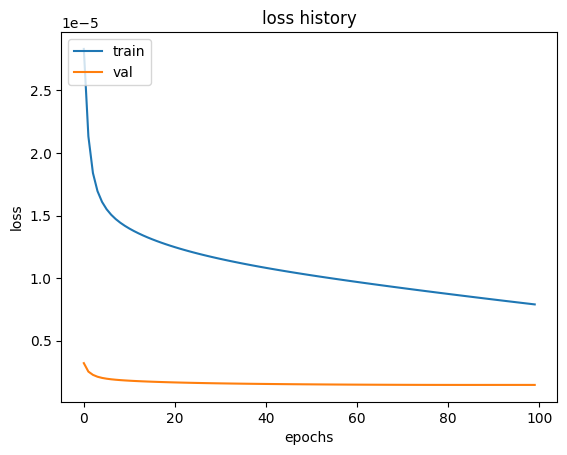

In [46]:
plt.clf()
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.title('loss history')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')

In [49]:
validation_dataset[0][0]

tensor([[[-1.9638, -0.6794,  1.1358,  ..., -2.0837, -2.1179, -2.1008],
         [-1.9638, -0.7137,  1.1015,  ..., -2.0837, -2.1179, -2.0837],
         [-1.9638, -0.7650,  1.0502,  ..., -2.0837, -2.1179, -2.0837],
         ...,
         [-1.8439, -1.9124, -1.9980,  ..., -2.1008, -2.1008, -2.1008],
         [-1.9980, -2.0494, -2.1008,  ..., -2.1008, -2.1008, -2.1008],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1008, -2.1008, -2.1008]],

        [[-1.8782, -0.5651,  1.2906,  ..., -1.8957, -1.9657, -1.9132],
         [-1.8782, -0.6001,  1.2556,  ..., -1.8957, -1.9657, -1.8957],
         [-1.8782, -0.6527,  1.2031,  ..., -1.8957, -1.9482, -1.8957],
         ...,
         [-1.7381, -1.8081, -1.8957,  ..., -2.0007, -2.0007, -2.0007],
         [-1.8957, -1.9482, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
         [-2.0182, -2.0182, -2.0182,  ..., -2.0007, -2.0007, -2.0007]],

        [[-1.6476, -0.3404,  1.5071,  ..., -1.7522, -1.8044, -1.7696],
         [-1.6476, -0.3753,  1.4722,  ..., -1

In [21]:
validation_dataset[0][0].shape

torch.Size([3, 480, 640])

In [23]:
#model = torch.load('save_weights/CSRNet_sigma16.pt')
model.eval()                   
with torch.no_grad():
    #img = torch.from_numpy(img)
    img = validation_dataset[0][0]
    img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    img = img.float()
    
    img = img.to(device)
    output = model(img)

In [39]:
output[1].shape

torch.Size([1, 1, 480, 640])

In [24]:
output = output[2][0].cpu().numpy().transpose((1, 2, 0))
output.shape

(480, 640, 1)

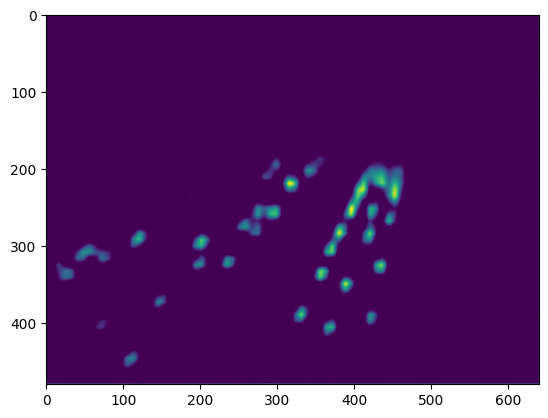

In [25]:
plt.imshow(output)

In [26]:
np.sum(output) / density_map_scale, validation_dataset[0][3]

(36.021585083007814, 43.0)

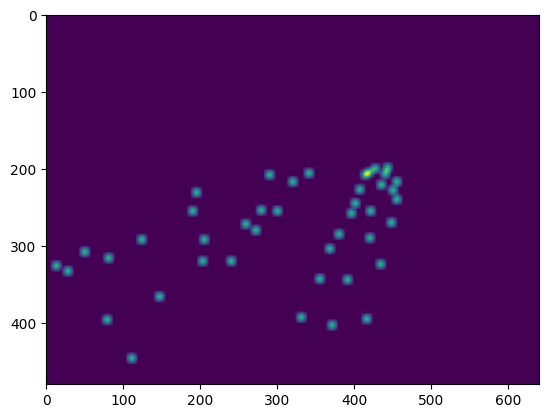

In [27]:
plt.imshow(validation_dataset[0][1].numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


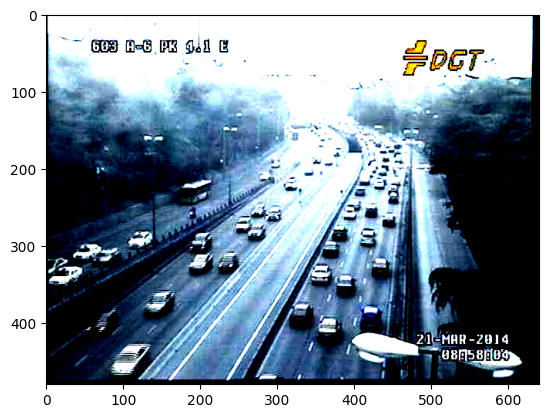

In [69]:
plt.imshow(validation_dataset[0][0].numpy().transpose((1, 2, 0)))